In [1]:
import numpy as np
import pyro
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import torch
from torch.distributions import constraints
import arviz as az

import pyro.contrib.gp as gp
import pyro.distributions as dist
from pyro.infer import NUTS
from pyro.infer import MCMC

from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

smoke_test = "CI" in os.environ
assert pyro.__version__.startswith('1.8.4')
pyro.set_rng_seed(0)

c:\Users\malth\anaconda3\envs\myenvyaml\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# B1

#### Plot helper functions

In [2]:
def plot(
    plot_observed_data=False,
    plot_predictions=False,
    n_prior_samples=0,
    model=None,
    kernel=None,
    n_test=500,
    ax=None,
    big_plot=False
):

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    if plot_observed_data:
        ax.plot(X.numpy(), y.numpy(), "kx")
    if plot_predictions:
        Xtest = torch.linspace(-1, 1, n_test)  # test inputs
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(Xtest, full_cov=True)
            else:
                mean, cov = model(Xtest, full_cov=True, noiseless=False)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        ax.plot(Xtest.numpy(), mean.numpy(), "r", lw=2)  # plot the mean
        ax.fill_between(
            Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
            (mean - 2.0 * sd).numpy(),
            (mean + 2.0 * sd).numpy(),
            color="C0",
            alpha=0.3,
        )
    if n_prior_samples > 0:  # plot samples from the GP prior
        Xtest = torch.linspace(-1, 1, n_test)  # test inputs
        noise = (
            model.noise
            if type(model) != gp.models.VariationalSparseGP
            else model.likelihood.variance
        )
        cov = kernel.forward(Xtest) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(
            torch.zeros(n_test), covariance_matrix=cov
        ).sample(sample_shape=(n_prior_samples,))
        ax.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)
    if big_plot == True:
        x_seq = np.arange(start=-1,stop=1,step=0.005)
        #plt.plot(x_seq,f(x_seq))
        #plt.xlabel("x")
        #plt.ylabel("f(x)")
        legend_elements = [Line2D([0], [0], color='r', lw=4, label='Predicted f(x)'),
                   Line2D([0], [0], marker='s', color='w', label='Confidence area',
                            markerfacecolor='cornflowerblue', markersize=15),
                   Line2D([0], [0], color='b', lw=2, label='f(x)'),
                   Line2D([0], [0], marker='x', color='w', label='Observed points',
                            markeredgecolor='0')]
        ax.legend(handles=legend_elements, loc='lower right')

    ax.set_xlim(-1, 1)

#### Define data

In [3]:
def f(x):
    return np.sin(20*x)+2*np.cos(14*x)-2*np.sin(6*x)

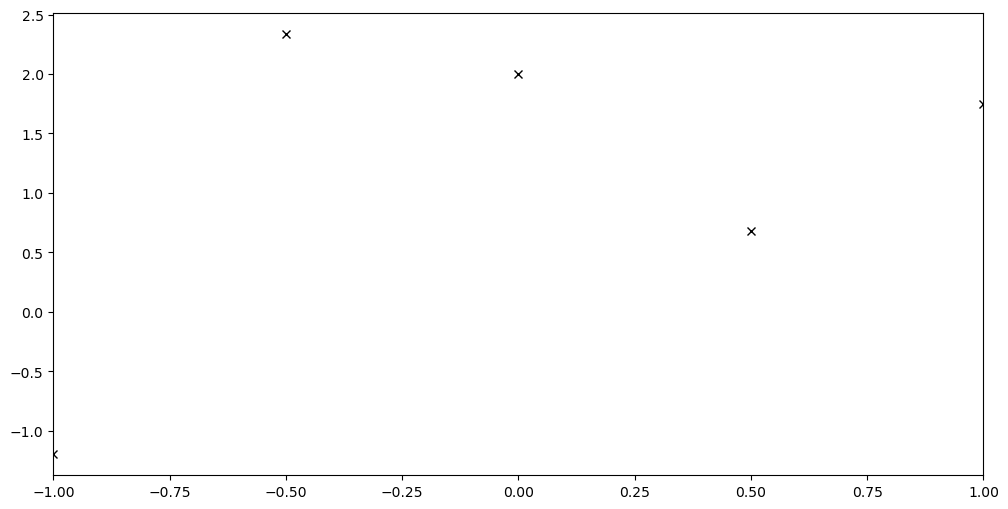

In [4]:
N = 5
X = torch.tensor([-1,-0.5,0,0.5,1])
y = f(X)
# Let's plot the observed data
plot(plot_observed_data=True)

#### Define model

In [20]:
kernel = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(6.0), lengthscale=torch.tensor(0.05) #defaults: 6.0 and 0.05
)
kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(-1.0), torch.tensor(1.0)))
kernel.variance = pyro.nn.PyroSample(dist.Uniform(torch.tensor(0.), torch.tensor(2.0)))
gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(0.0001)) 

#### Inference

In [6]:
# MCMC
hmc_kernel = NUTS(gpr.model)
mcmc = MCMC(hmc_kernel, num_samples=200, num_chains=5, warmup_steps=100)
mcmc.run()

Warmup [1]:   0%|          | 0/300 [00:00, ?it/s]






















Warmup [1]:   0%|          | 1/300 [00:02,  2.59s/it, step size=2.25e-01, acc. prob=1.000]




Warmup [1]:   1%|▏         | 4/300 [00:02,  1.93it/s, step size=8.82e-02, acc. prob=0.750]

Warmup [1]:   4%|▎         | 11/300 [00:02,  6.45it/s, step size=5.67e-01, acc. prob=0.837]


















Warmup [1]:   5%|▌         | 15/300 [00:03,  6.41it/s, step size=4.25e-01, acc. prob=0.822]


Warmup [1]:   6%|▌         | 18/300 [00:03,  8.25it/s, step size=4.41e-01, acc. prob=0.819]




Warmup [1]:   8%|▊         | 24/300 [00:03, 11.93it/s, step size=3.89e-01, acc. prob=0.813]






Warmup [1]:   9%|▉         | 27/300 [00:03, 13.64it/s, step size=2.54e-01, acc. prob=0.806]







Warmup [1]:  10%|█         | 30/300 [00:04, 15.21it/s, step size=7.79e-01, acc. prob=0.820]








Warmup [1]:  11%|█         | 33/300 [00:04, 13.28it/s, step size=2.59e-01, acc. prob=0.806]




Warmup [1]:  12%|█▏        | 37/300 [00:04, 17.5

##### Plots

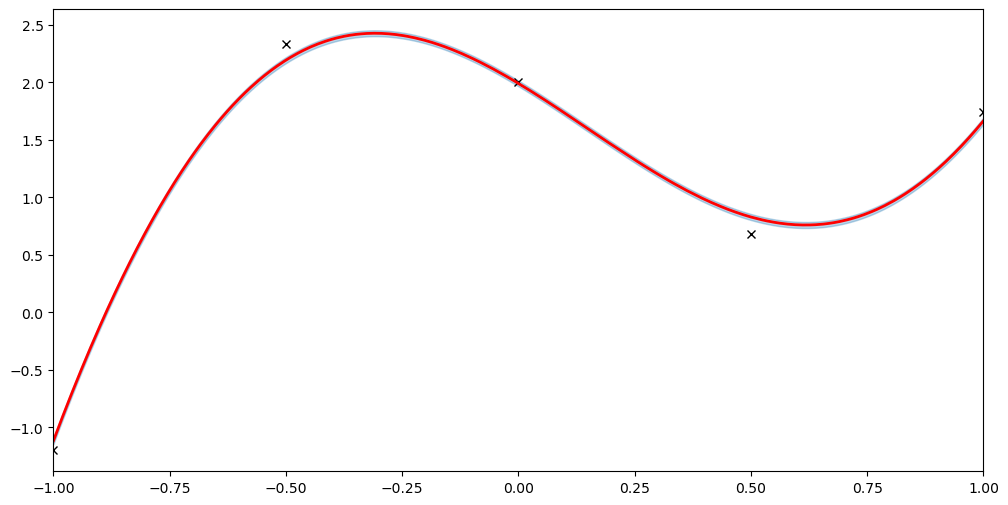

In [7]:
plot(model=gpr, plot_observed_data=True, plot_predictions=True)

#### NUTS Sampling

In [71]:
# Get the samples
posterior_samples = mcmc.get_samples(num_samples=500)

Text(0, 0.5, 'log Variance')

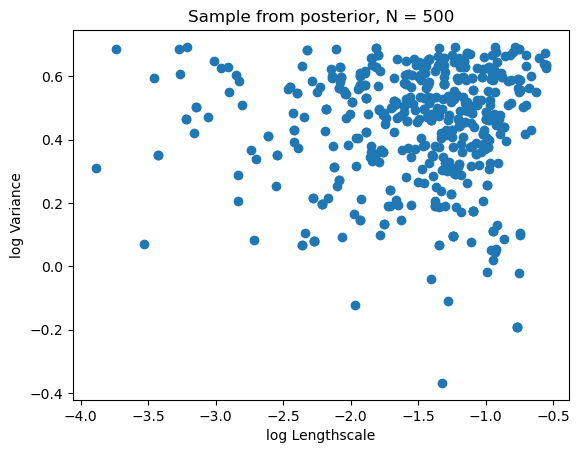

In [77]:
plt.scatter(torch.log(posterior_samples['kernel.lengthscale']),torch.log(posterior_samples['kernel.variance']))
plt.title('Sample from posterior, N = 500')
plt.xlabel('log Lengthscale')
plt.ylabel('log Variance')

In [91]:
posterior_predictive = pyro.infer.Predictive(gpr.model, posterior_samples)
prior_predictive = pyro.infer.Predictive(gpr.model, num_samples=500)

In [95]:
#obs_pred=posterior_predictive['kernel.variance']
print(posterior_predictive)

Predictive()


#### Diagnostics

In [10]:
Xnew = torch.tensor([-0.75, -0.25, 0.25, 0.75])
f_loc, f_cov = gpr(Xnew, full_cov=True)

In [11]:
data = az.from_pyro(mcmc)
summary = az.summary(data)
print(summary) 

                     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.lengthscale  0.252  0.120    0.02    0.445      0.007    0.005   
kernel.variance     1.577  0.285    1.08    1.999      0.013    0.010   

                    ess_bulk  ess_tail  r_hat  
kernel.lengthscale     314.0     320.0   1.02  
kernel.variance        369.0     219.0   1.01  


c:\Users\malth\anaconda3\envs\myenvyaml\lib\site-packages\arviz\data\io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


array([<AxesSubplot: title={'center': 'kernel.lengthscale'}>,
       <AxesSubplot: title={'center': 'kernel.variance'}>], dtype=object)

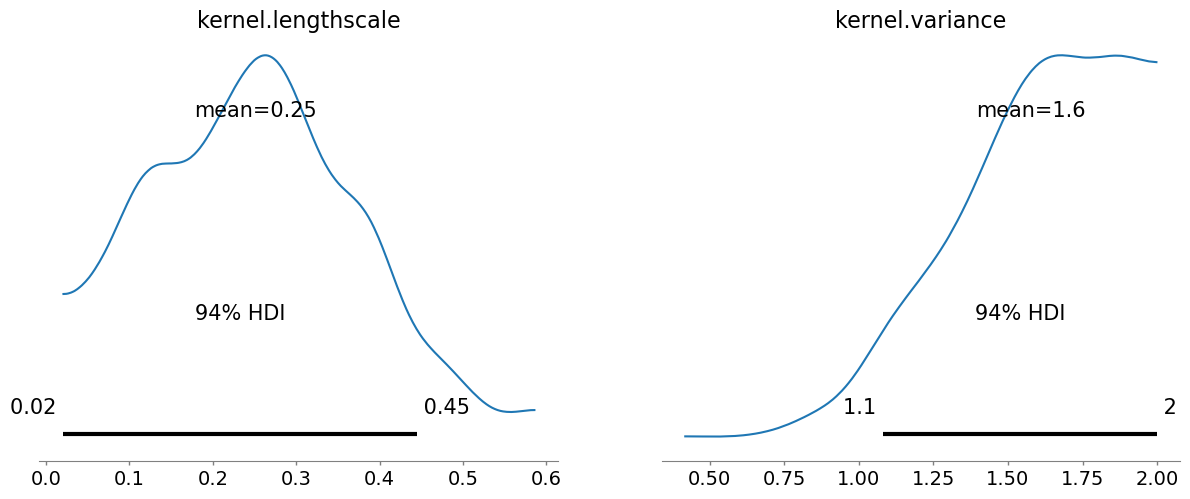

In [88]:
az.plot_posterior(data)

array([[<AxesSubplot: title={'center': 'kernel.lengthscale'}>,
        <AxesSubplot: title={'center': 'kernel.lengthscale'}>],
       [<AxesSubplot: title={'center': 'kernel.variance'}>,
        <AxesSubplot: title={'center': 'kernel.variance'}>]], dtype=object)

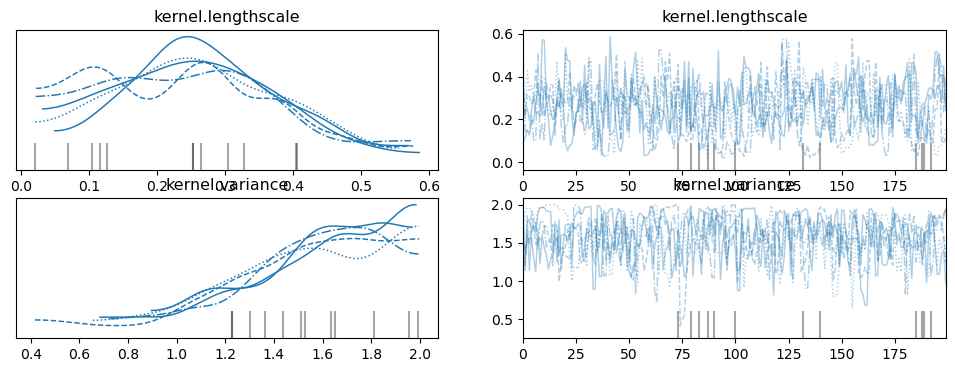

In [13]:
az.plot_trace(data)

#### Big plot

Add confidence area and $f(x)$

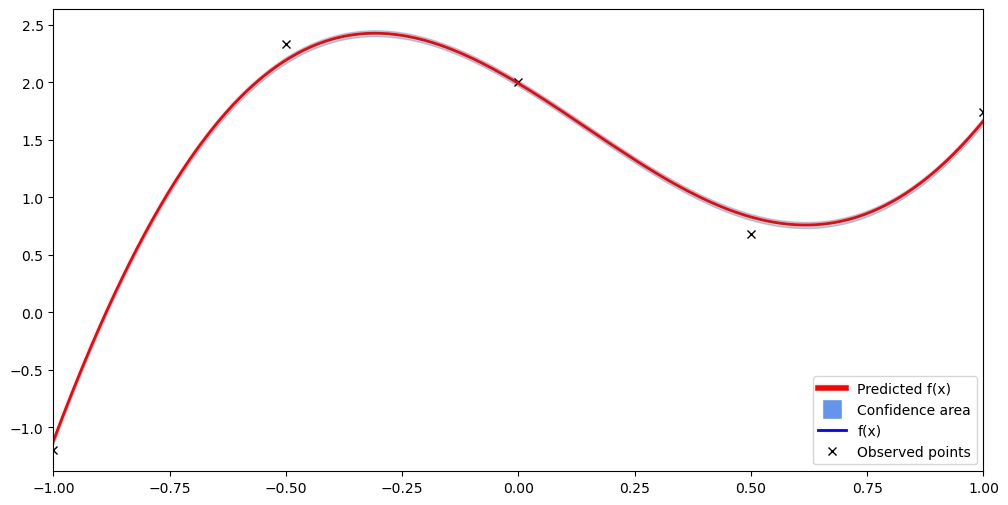

In [14]:
x_seq = np.arange(start=-1,stop=1,step=0.005)
plot(model=gpr, plot_observed_data=True, plot_predictions=True, big_plot=True)
#plt.plot(x_seq,f(x_seq))
#plt.xlabel("x")
#plt.ylabel("f(x)")
#plt.legend() #Elaborate on legend

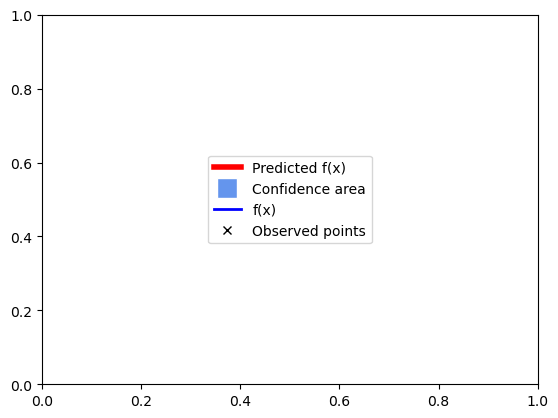

In [16]:
# Plot sandbox
legend_elements = [Line2D([0], [0], color='r', lw=4, label='Predicted f(x)'),
                   Line2D([0], [0], marker='s', color='w', label='Confidence area',
                            markerfacecolor='cornflowerblue', markersize=15),
                   Line2D([0], [0], color='b', lw=2, label='f(x)'),
                   Line2D([0], [0], marker='x', color='w', label='Observed points',
                            markeredgecolor='0')]

fig, ax = plt.subplots()
ax.legend(handles=legend_elements, loc='center')

plt.show()

# B2

In [36]:
k = 10
np.random.seed(3)
X_star = torch.tensor(np.linspace(-1,1,num=200))

In [33]:
for i in range(0,k):
    f_sample = 